In [91]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Data Cleaning**

In [194]:
def wrangle(pathfile, resample_rule="1D"):
    # Read data
    df = pd.read_csv(pathfile)
    
    # Specify Category
    furniture = df.loc[df['Category'] == 'Furniture']
    
    # Choose the columns we want
    furniture = furniture[['Order Date','Sales']].sort_values('Order Date')
    
    # Indexing by Date
    furniture = furniture.set_index('Order Date')
    
    # group the sales by the Date
    furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
    
    # Remove outliers
    df = furniture[furniture["Sales"] < 7000].set_index('Order Date')
    
    return df

In [195]:
df = wrangle('/kaggle/input/superstore-time-series-dataset/superstore_train.csv')
df.head(4)

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940


In [245]:
df.index.min(), df.index.max()

('2014-01-06', '2017-12-30')

In [246]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 793 entries, 2014-01-06 to 2017-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   793 non-null    float64
dtypes: float64(1)
memory usage: 44.7+ KB


In [248]:
df.describe()

,Sales
count,793.000000
mean,728.649422
std,856.238226
min,1.988000
25%,132.901000
50%,441.960000
75%,1024.208000
max,5496.174000


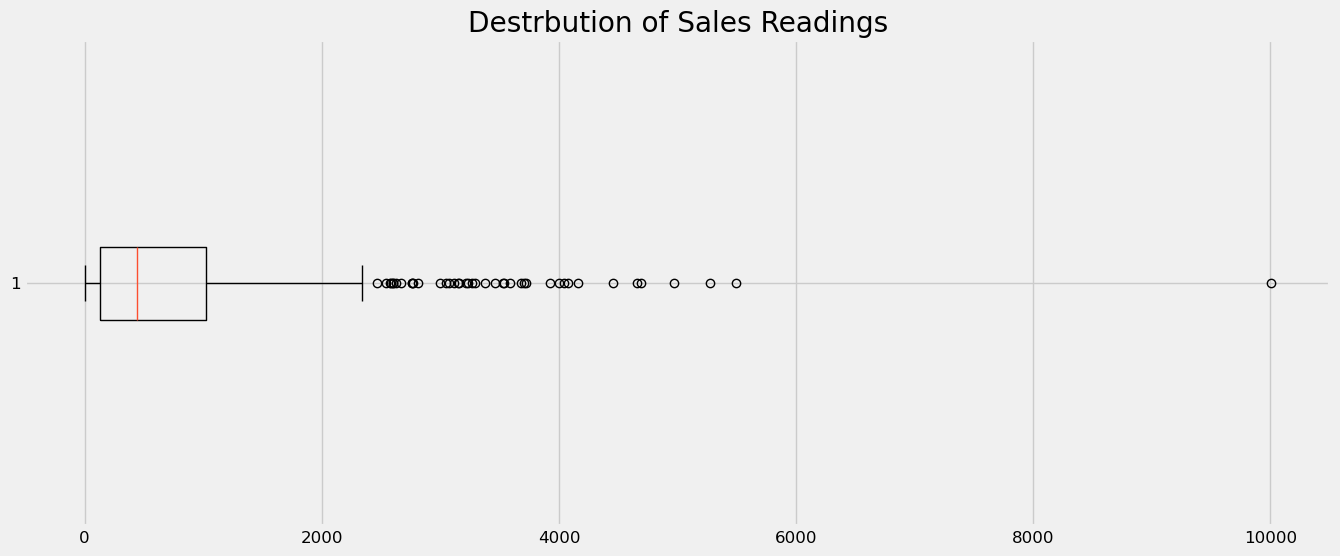

In [62]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.boxplot(x = df["Sales"], vert = False);
plt.title("Destrbution of Sales Readings");

**We have some outliers so we will drop anything above 7000, edit the wrangle function**

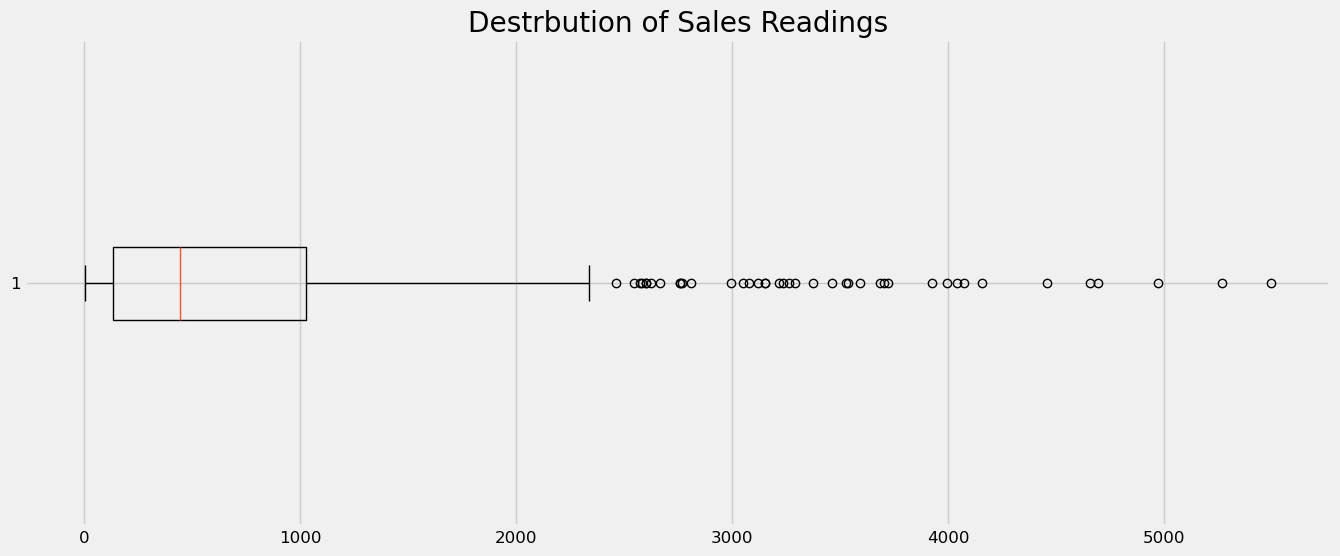

In [69]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.boxplot(x = df["Sales"], vert = False);
plt.title("Destrbution of Sales Readings");

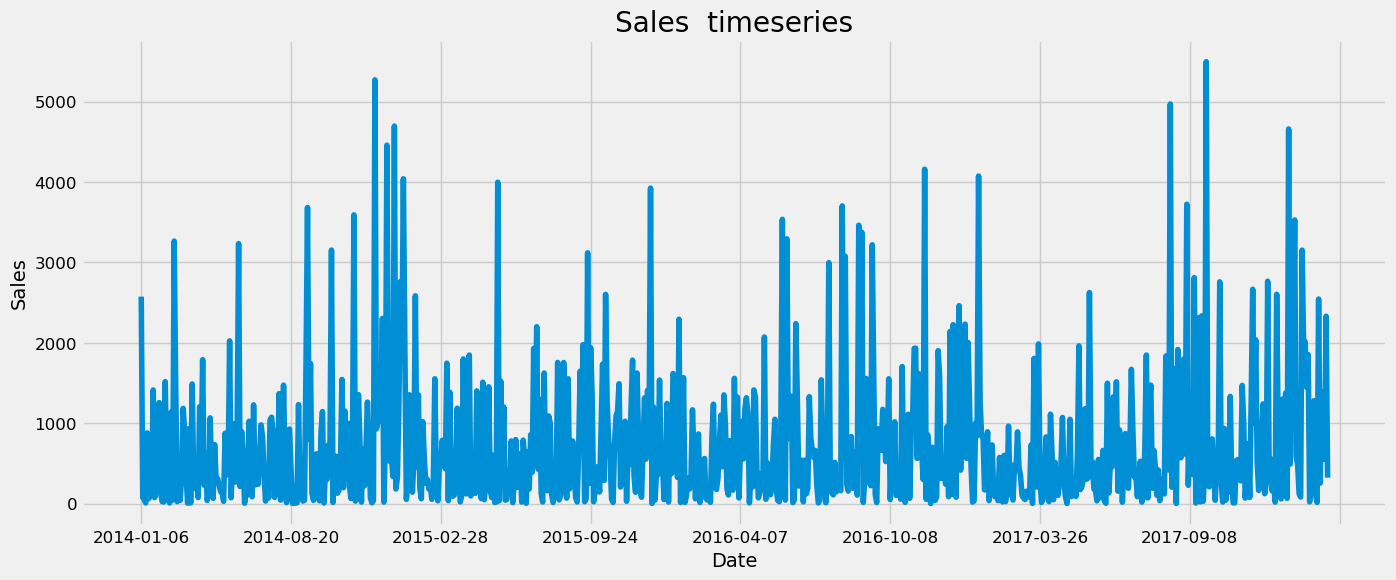

In [70]:
fig, ax = plt.subplots(figsize=(15, 6))
df["Sales"].plot(xlabel = "Date", ylabel = "Sales", title = "Sales  timeseries", ax =ax);

In [74]:
# Taking a window of week and calculate the mean
df["Sales"].rolling(14).mean().isnull().sum()

13

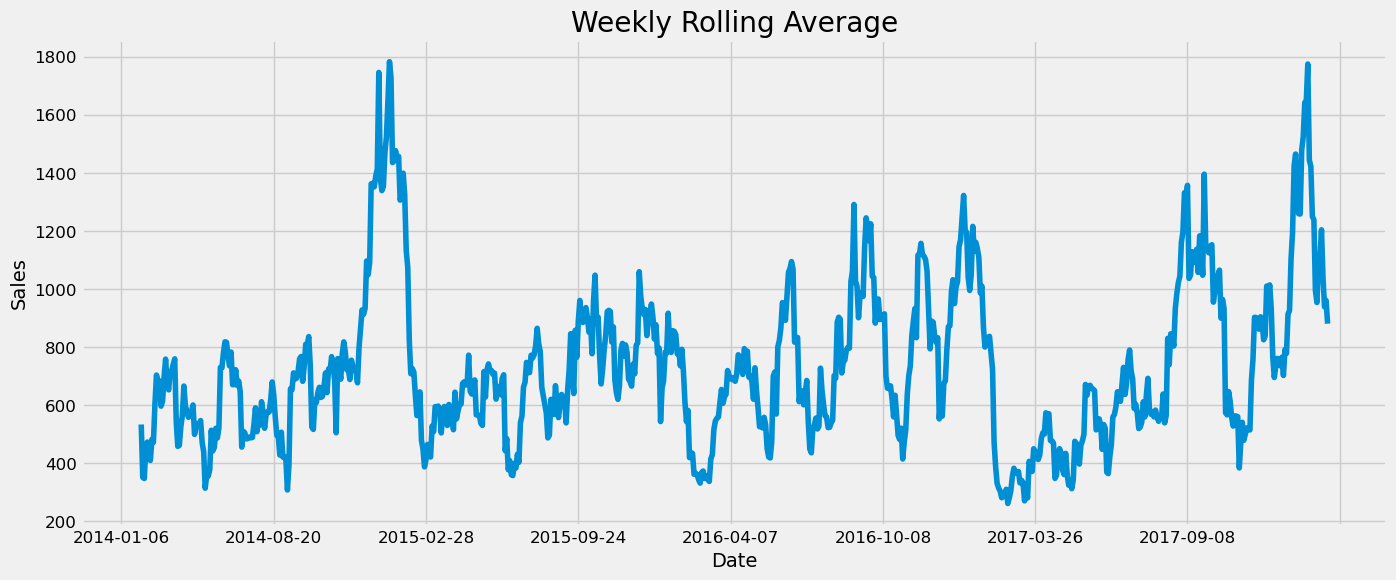

In [75]:
fig, ax = plt.subplots(figsize=(15, 6))
df["Sales"].rolling(14).mean().plot(ax=ax, xlabel = "Date", ylabel = "Sales", title="Weekly Rolling Average");

In [77]:
from statsmodels.tsa.stattools import adfuller

# Assume 'sales' is your time series data
result = adfuller(df['Sales'])

# Extract the p-value from the test result
p_value = result[1]

# Check if the p-value is less than 0.05 (or another significance level of your choice)
if p_value < 0.05:
    print("The time series has no unit root and is stationary, indicating no trend.")
else:
    print("The time series has a unit root and is non-stationary, indicating a trend.")


The time series has no unit root and is stationary, indicating no trend.


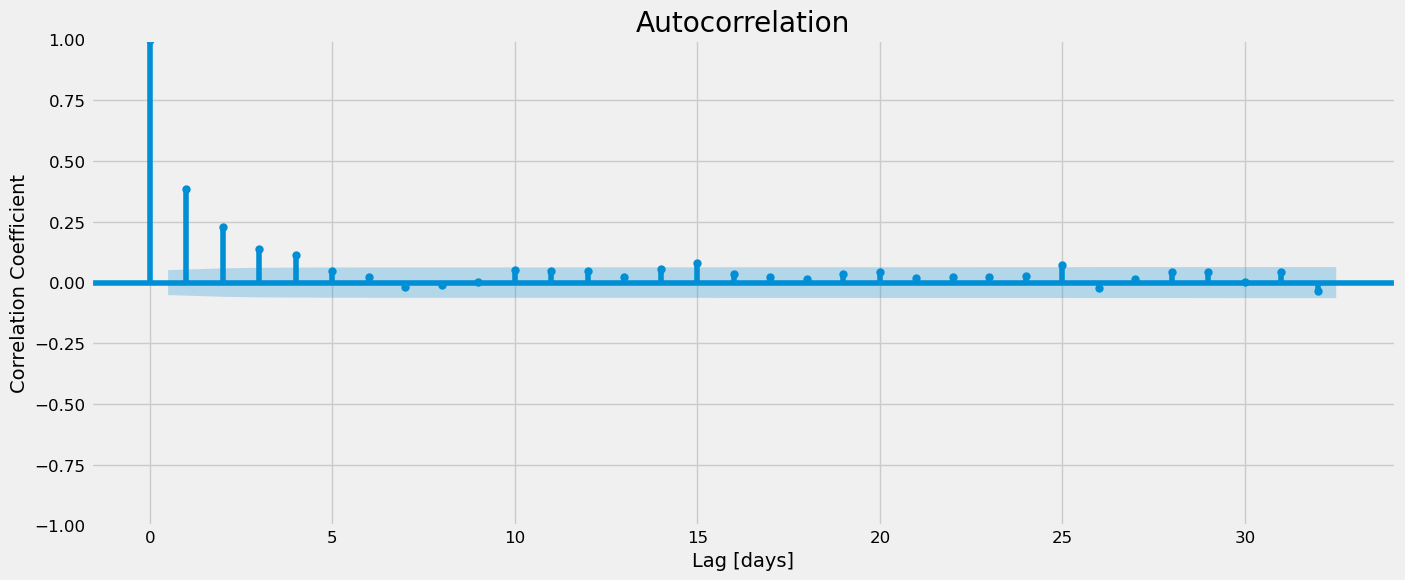

In [142]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(df, ax= ax)
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

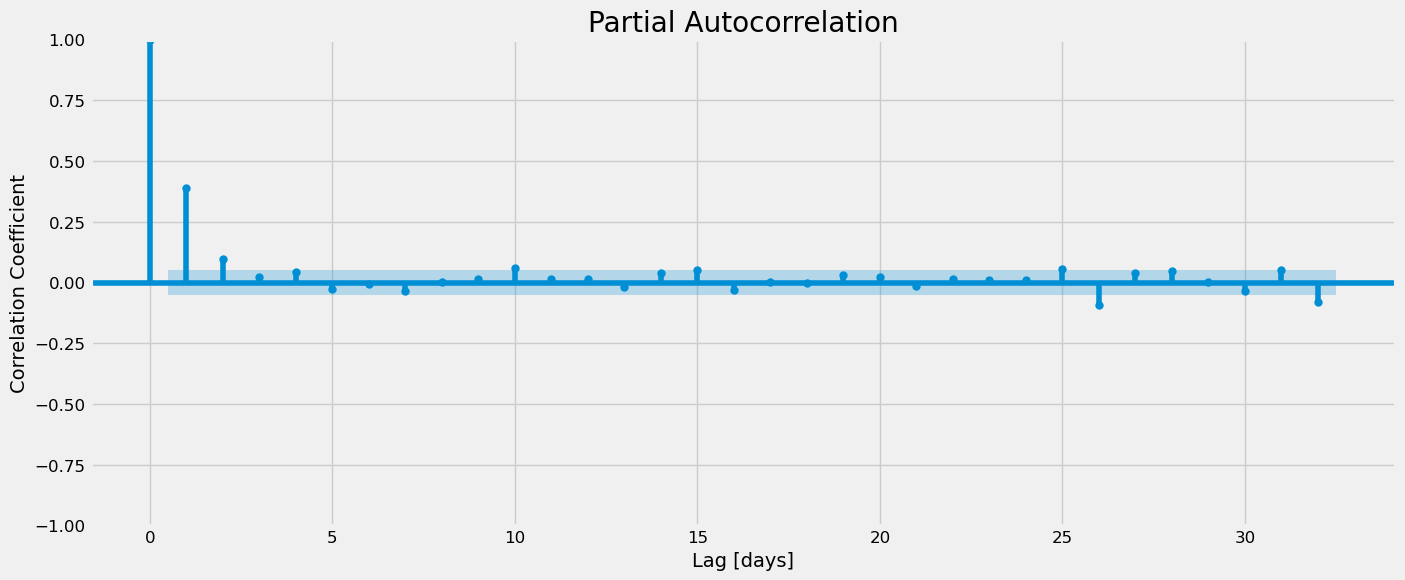

In [143]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(df, ax= ax)
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

In [199]:
import pandas as pd
import sqlite3

# Connect to the database
conn = sqlite3.connect('database_name.db')

# Read the CSV file into a pandas dataframe
#df = pd.read_csv('/kaggle/input/superstore-time-series-dataset/superstore_train.csv')

# Create a new SQL table from the dataframe
df.to_sql('table_name', conn, if_exists='replace', index=True)

# Query the data from the table
cursor = conn.cursor()
cursor.execute('SELECT * FROM table_name')
rows = cursor.fetchall()
# for row in rows:
#     print(row)
#cursor.close()
#conn.close()


# Data Analysis using SQL

In [200]:
tables = pd.read_sql("""SELECT * FROM table_name""", conn)
tables

,Order Date,Sales
0,2014-01-06,2573.8200
1,2014-01-07,76.7280
2,2014-01-10,51.9400
3,2014-01-11,9.9400
4,2014-01-13,879.9390
...,...,...
788,2017-12-24,1393.4940
789,2017-12-25,811.4540
790,2017-12-28,551.2568
791,2017-12-29,2330.7180


In [216]:
# Use the LEAD window function to create a new column sales_next that displays the sales of the 
# next row in the dataset. 
# This function will help you quickly compare a given row’s values and values in the next row.
sales_next = pd.read_sql(
 """
    SELECT "Order Date", "Sales",
        LEAD("Sales", 1, "Sales") OVER (ORDER BY "Order Date") AS sales_next
    FROM 
        table_name;
"""
    , conn)

sales_next



,Order Date,Sales,sales_next
0,2014-01-06,2573.8200,76.7280
1,2014-01-07,76.7280,51.9400
2,2014-01-10,51.9400,9.9400
3,2014-01-11,9.9400,879.9390
4,2014-01-13,879.9390,61.9600
...,...,...,...
788,2017-12-24,1393.4940,811.4540
789,2017-12-25,811.4540,551.2568
790,2017-12-28,551.2568,2330.7180
791,2017-12-29,2330.7180,323.1360


In [220]:
# Create a new column sales_previous to display the values of the row above a given row.
sales_previous = pd.read_sql(
 """
    SELECT 
        "Order Date", 
        "Sales", 
        LAG("Sales") OVER (ORDER BY "Order Date") AS sales_previous 
    FROM 
        table_name;

"""
    , conn)

sales_previous

,Order Date,Sales,sales_previous
0,2014-01-06,2573.8200,NaN
1,2014-01-07,76.7280,2573.8200
2,2014-01-10,51.9400,76.7280
3,2014-01-11,9.9400,51.9400
4,2014-01-13,879.9390,9.9400
...,...,...,...
788,2017-12-24,1393.4940,254.6540
789,2017-12-25,811.4540,1393.4940
790,2017-12-28,551.2568,811.4540
791,2017-12-29,2330.7180,551.2568


In [222]:
# Rank the data based on sales in descending order using the RANK function.

rank = pd.read_sql(
 """
    SELECT "Order Date", "Sales", RANK() OVER (ORDER BY "Sales" DESC) AS sales_rank
    FROM table_name;
"""
    , conn)

rank

,Order Date,Sales,sales_rank
0,2017-09-20,5496.1740,1
1,2014-11-17,5270.0800,2
2,2017-08-17,4970.1140,3
3,2014-12-12,4695.6005,4
4,2017-11-28,4659.1400,5
...,...,...,...
788,2015-12-03,2.9600,789
789,2017-03-20,2.9100,790
790,2017-08-23,2.7840,791
791,2016-11-19,2.3280,792


In [224]:
# Use common SQL commands and aggregate functions to show the monthly and daily sales averages.
# Rank the data based on sales in descending order using the RANK function.

monthly_sales_avg = pd.read_sql(
 """
    SELECT
        DATE("Order Date") AS month,
        AVG("Sales") AS monthly_sales_avg
    FROM
        table_name
    GROUP BY
        month
    ORDER BY
        month;

"""
    , conn)

monthly_sales_avg

,month,monthly_sales_avg
0,2014-01-06,2573.8200
1,2014-01-07,76.7280
2,2014-01-10,51.9400
3,2014-01-11,9.9400
4,2014-01-13,879.9390
...,...,...
788,2017-12-24,1393.4940
789,2017-12-25,811.4540
790,2017-12-28,551.2568
791,2017-12-29,2330.7180


In [225]:
# Use common SQL commands and aggregate functions to show the monthly and daily sales averages.
# Rank the data based on sales in descending order using the RANK function.

daily_sales_avg = pd.read_sql(
 """
    SELECT
        "Order Date",
        AVG("Sales") AS daily_sales_avg
    FROM
        table_name
    GROUP BY
        "Order Date"
    ORDER BY
        "Order Date";


"""
    , conn)


daily_sales_avg

,Order Date,daily_sales_avg
0,2014-01-06,2573.8200
1,2014-01-07,76.7280
2,2014-01-10,51.9400
3,2014-01-11,9.9400
4,2014-01-13,879.9390
...,...,...
788,2017-12-24,1393.4940
789,2017-12-25,811.4540
790,2017-12-28,551.2568
791,2017-12-29,2330.7180


In [237]:
# Analyze discounts on two consecutive days.

discounts_2Days = pd.read_sql(
 """
    SELECT
        "Order Date",
        "Sales",
        LAG("Sales") OVER (ORDER BY "Order Date") AS Prev_Sales,
        LEAD("Sales") OVER (ORDER BY "Order Date") AS Next_Sales,
        CASE
            WHEN "Sales" < "Prev_Sales" OR "Sales" < "Next_Sales" THEN 'Discount'
            ELSE 'No Discount'
        END AS Discount_Status
    FROM
        table_name
    ORDER BY
        "Order Date"

"""
    , conn)

discounts_2Days

,Order Date,Sales,Prev_Sales,Next_Sales,Discount_Status
0,2014-01-06,2573.8200,NaN,76.7280,Discount
1,2014-01-07,76.7280,2573.8200,51.9400,Discount
2,2014-01-10,51.9400,76.7280,9.9400,Discount
3,2014-01-11,9.9400,51.9400,879.9390,Discount
4,2014-01-13,879.9390,9.9400,61.9600,Discount
...,...,...,...,...,...
788,2017-12-24,1393.4940,254.6540,811.4540,Discount
789,2017-12-25,811.4540,1393.4940,551.2568,Discount
790,2017-12-28,551.2568,811.4540,2330.7180,Discount
791,2017-12-29,2330.7180,551.2568,323.1360,Discount


In [241]:
# Evaluate moving averages using the window functions.

moving_averages = pd.read_sql(
 """
    SELECT "Order Date", "Sales", 
           AVG("Sales") OVER (ORDER BY "Order Date" ROWS BETWEEN 3 PRECEDING AND CURRENT ROW) AS moving_avg
    FROM table_name


"""
    , conn)

moving_averages

,Order Date,Sales,moving_avg
0,2014-01-06,2573.8200,2573.820000
1,2014-01-07,76.7280,1325.274000
2,2014-01-10,51.9400,900.829333
3,2014-01-11,9.9400,678.107000
4,2014-01-13,879.9390,254.636750
...,...,...,...
788,2017-12-24,1393.4940,1052.012000
789,2017-12-25,811.4540,1250.895500
790,2017-12-28,551.2568,752.714700
791,2017-12-29,2330.7180,1271.730700
